In [6]:
import numpy as np
import xarray as xr
from cmocean import cm as cmo  
import matplotlib.pyplot as plt
import gsw

%matplotlib inline

## Load glider sections from 2022 and 2015 case studies, as well as mean section from other missions at 33.5S latitude

In [3]:
ds = xr.open_dataset('../data/MnTransect.nc')
sect_2015 = xr.open_dataset('../data/glidersection_APR2015.nc')
sect_2022 = xr.open_dataset('../data/glidersection_APR2022.nc')

### Change some variable names to make them consistent 

In [4]:
ds['salt_abs'] = ds.ABSS_MEAN
ds['temp_cons'] = ds.CONST_MEAN

### Calculate alpha, beta and gravity using GSW toolbox

In [7]:
ds['alpha'] = gsw.density.alpha(ds.ABSS_MEAN,ds.CONST_MEAN,ds.PRES_MEAN)
ds['beta'] = gsw.density.beta(ds.ABSS_MEAN,ds.CONST_MEAN,ds.PRES_MEAN)
ds['grav'] = gsw.grav(-33.5, ds.PRES_MEAN).transpose()

### Define gradient function

In [8]:
def calculate_theta_derivative(z, theta):
    dz = np.gradient(z)  # Calculate the vertical spacing (dz)
    dtheta_dz = np.gradient(theta) / dz  # Calculate the centered difference of theta with respect to z

    return dtheta_dz

### Calculate dz (same for all sections)

In [9]:
dz = np.gradient(ds.PRES)  # Calculate the vertical spacing (dz)

### Define function to calculate the Stratification Control Index following Caneill et al. (2022), JPO 
https://doi.org/10.1175/JPO-D-21-0295.1

SCI = $ \frac{N^2_\theta - N^2_S}{N^2_\theta + N^2_\theta}$,

$N^2 = - \frac{g}{\rho_0} \frac{\partial \rho_\theta}{\partial z} = N^2_\theta + N^2_S$,

$N^2_\theta = g \alpha \frac{\partial \theta}{\partial z}$,

$N^2_S = g \beta \frac{\partial S_A}{\partial z}$

If SCI >= 1 it's an alpha ocean, stratified by temperature, destratified by salinity,
If SCI <= -1, it's a beta ocean, stratified by salinity and destratified by temperature,
-1<SCI<1, it's a transition zone, stratified by both temperature and salinity

In [10]:
def calc_SCI(sect):
    SCI_list=[]
    for i in range(0,len(sect.DIST)):

        # Calculate the partial derivative of theta with respect to z
        dtheta_dz = calculate_theta_derivative(sect.isel(DIST=i).PRES, sect.isel(DIST=i).temp_cons)
        N_square_theta = sect.grav.isel(DIST=i)*sect.alpha.isel(DIST=i)*(dtheta_dz)
        # Calculate the partial derivative of theta with respect to z
        dsalt_dz = calculate_theta_derivative(sect.isel(DIST=i).PRES, sect.isel(DIST=i).salt_abs)
        N_square_salt = sect.isel(DIST=i).grav*sect.isel(DIST=i).beta*(dsalt_dz)
        SCI_temp = (N_square_theta-N_square_salt)/(N_square_theta+N_square_salt)
        SCI_list.append(SCI_temp)

    SCI = xr.concat(SCI_list,'distance')
    return SCI

In [11]:
SCI_mean = calc_SCI(ds)
SCI_2015 = calc_SCI(sect_2015)
SCI_2022 = calc_SCI(sect_2022)

# Plot

Text(0.5, 0, 'Stratification control index')

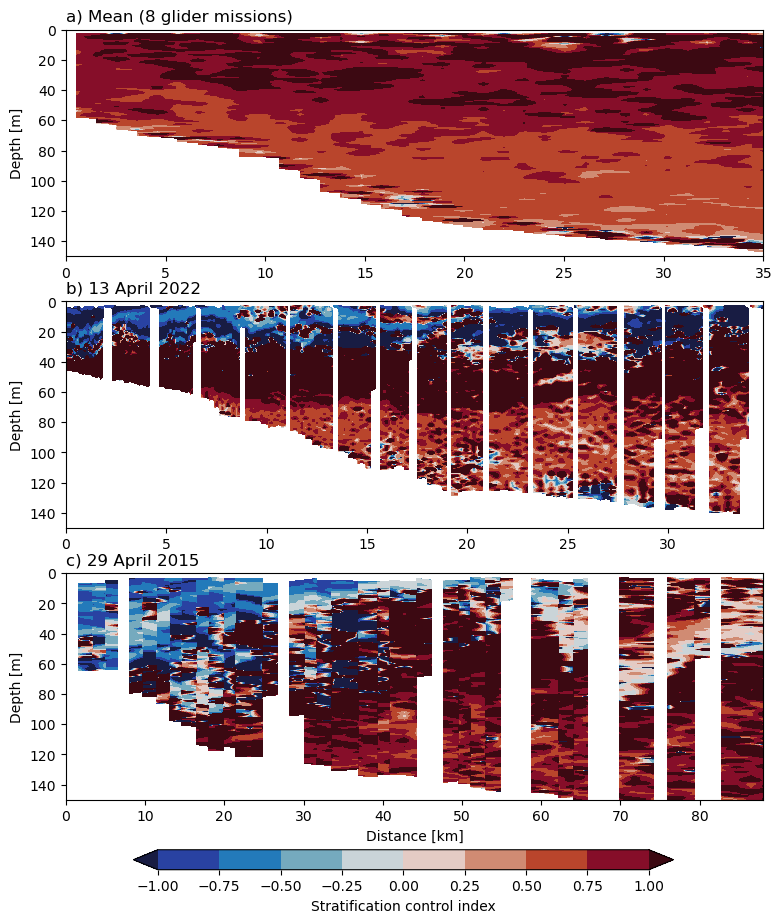

In [13]:
levs=9
fig = plt.figure(figsize=(9,10))

plt.subplot(311)
fill = SCI_mean.plot.contourf(x='DIST',vmin=-1,vmax=1,levels=levs,cmap=cmo.balance, add_colorbar=False)
plt.ylim(0,150)
plt.xlim(0,35)
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('')
plt.title('a) Mean (8 glider missions)', loc='left')

plt.subplot(312)
SCI_2022.plot.contourf(x='DIST',vmin=-1,vmax=1,levels=levs,cmap=cmo.balance, add_colorbar=False)
plt.ylim(0,150)
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('')
plt.title('b) 13 April 2022', loc='left')

plt.subplot(313)
SCI_2015.plot.contourf(x='DIST',vmin=-1,vmax=1,levels=levs,cmap=cmo.balance, add_colorbar=False)
plt.ylim(0,150)
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('Distance [km]')
plt.title('c) 29 April 2015', loc='left')

cbar_ax = fig.add_axes([0.2, 0.04, .6, .02]) #left, bottom, width, height
fig.colorbar(fill, cax=cbar_ax, orientation="horizontal",extend='both')
plt.xlabel('Stratification control index')